# Dataset Exploration

---
In this notebook, we perform a Jet identification task using a multiclass classifier based on a 
Dense Neural Network (DNN). The problem consists on identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on set of physics-motivated high-level features.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
Open the HDF5 files in the data/ directory and append them to a target and jetImage dataset

In [3]:
target = np.array([])
features = np.array([])
for fileIN in glob.glob("data/jetImage_*_100p_*h5"):
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, features.shape)

Appending data/jetImage_7_100p_80000_90000.h5
Appending data/jetImage_7_100p_70000_80000.h5
Appending data/jetImage_7_100p_0_10000.h5
Appending data/jetImage_7_100p_10000_20000.h5
Appending data/jetImage_7_100p_40000_50000.h5
Appending data/jetImage_7_100p_60000_70000.h5
Appending data/jetImage_7_100p_30000_40000.h5
Appending data/jetImage_7_100p_50000_60000.h5
(80000, 5) (80000, 16)


The dataset consists of 80000 jets, each represented by 16 features

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(53600, 16) (26400, 16) (53600, 5) (26400, 5)


# DNN model building

In [5]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Flatten
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
input_shape = X_train.shape[1]
dropoutRate = 0.25

In [23]:
####
inputArray = Input(shape=(input_shape,))
#
x = Dense(40, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputArray, outputs=output)

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 40)                680       
_________________________________________________________________
dropout_7 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                820       
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
__________

We now train the model

In [25]:
batch_size = 128
n_epochs = 50

In [26]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 53600 samples, validate on 26400 samples
Epoch 1/50
 - 2s - loss: 1.8866 - val_loss: 1.4770
Epoch 2/50
 - 1s - loss: 1.4879 - val_loss: 1.3986
Epoch 3/50
 - 1s - loss: 1.4202 - val_loss: 1.3624
Epoch 4/50
 - 1s - loss: 1.3806 - val_loss: 1.3360
Epoch 5/50
 - 1s - loss: 1.3480 - val_loss: 1.3295
Epoch 6/50
 - 1s - loss: 1.3200 - val_loss: 1.3158
Epoch 7/50
 - 1s - loss: 1.2908 - val_loss: 1.2650
Epoch 8/50
 - 1s - loss: 1.2619 - val_loss: 1.2419
Epoch 9/50
 - 1s - loss: 1.2225 - val_loss: 1.1635
Epoch 10/50
 - 1s - loss: 1.1851 - val_loss: 1.1385
Epoch 11/50
 - 1s - loss: 1.1643 - val_loss: 1.0758
Epoch 12/50
 - 1s - loss: 1.1377 - val_loss: 1.0634
Epoch 13/50
 - 1s - loss: 1.1114 - val_loss: 1.0612
Epoch 14/50
 - 1s - loss: 1.0967 - val_loss: 1.0492
Epoch 15/50
 - 1s - loss: 1.0868 - val_loss: 1.0585
Epoch 16/50
 - 1s - loss: 1.0808 - val_loss: 1.0768
Epoch 17/50
 - 1s - loss: 1.0705 - val_loss: 1.0178
Epoch 18/50
 - 1s - loss: 1.0677 - val_loss: 1.0831
Epoch 19/50
 - 1s - los

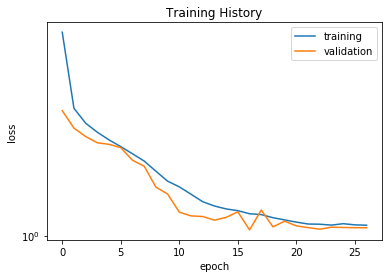

In [27]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

We save on disk the best model, result of the training, to be then use for inference

In [28]:
model_json = model.to_json()
with open("models/jetTagger_DNN.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("models/jetTagger_DNN.h5")

# Building the ROC Curves

In [29]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

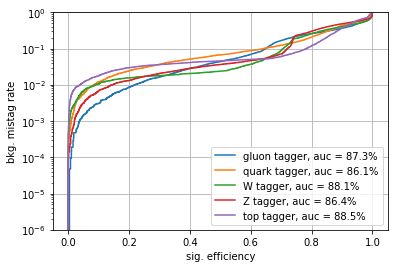

In [30]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()